In [1]:
%pylab inline
%load_ext Cython

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree, SuchLinkedTrees, pearson
import seaborn

### Calculating distances

`SuchTree` has two ways approaches for calculating distances. One pair a time, or
several large groups of pairs at once. The large groups is more efficient because
it does each calculation without the interpreter's overhead. 

Note that the dendrograms in the cluster maps are re-computed from the distances 
in the matrix using neighbor joining, and so they do not exactly match the phylogeny
which was computed using a different method.

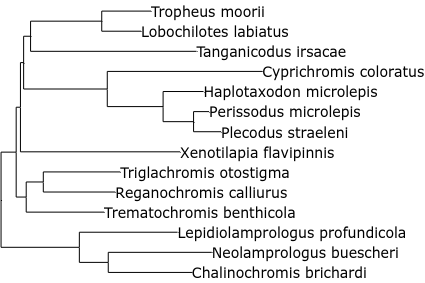

In [3]:
from ete2 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0

ete_tree = Tree( '../fishpoo/mcgee_trimmed.tree' )

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 10
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=120, units="mm", tree_style=ts)

In [3]:
#T = SuchTree( 'SuchTree/tests/test.tree')
T = SuchTree( '../fishpoo/mcgee_trimmed.tree' )

In [4]:
D1 = zeros( ( len(T.leafs),len(T.leafs) ) )
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D1[i,j] = T.distance( a, b )

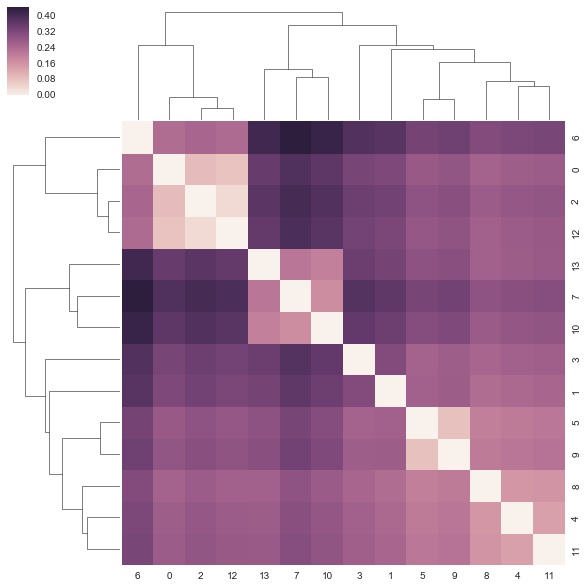

In [5]:
seaborn.clustermap(D1)

In [7]:
D2_list = []
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D2_list.append( ( a, b ) )
D2_array = array( D2_list )
D2 = T.distances( D2_array )
D2 = D2.reshape( ( len(T.leafs), len(T.leafs) ) )

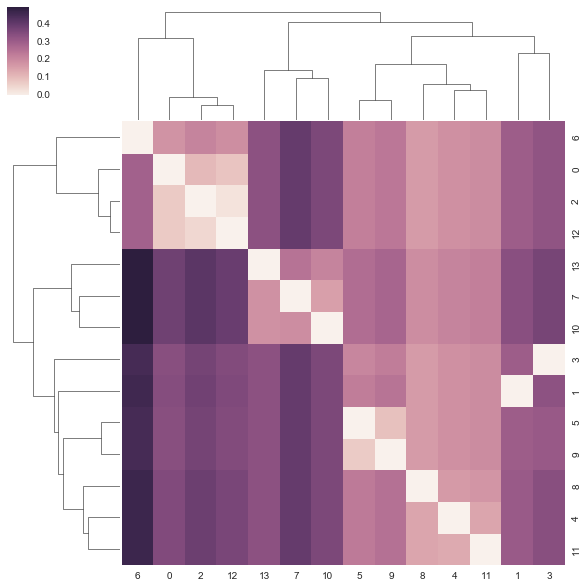

In [8]:
seaborn.clustermap(D2)

### Loading data from URLs

SuchTree can also import data from the internets. Here is the distance matrix for 
the penguins, from the [Global Phylogeny of Birds](http://birdtree.org/).

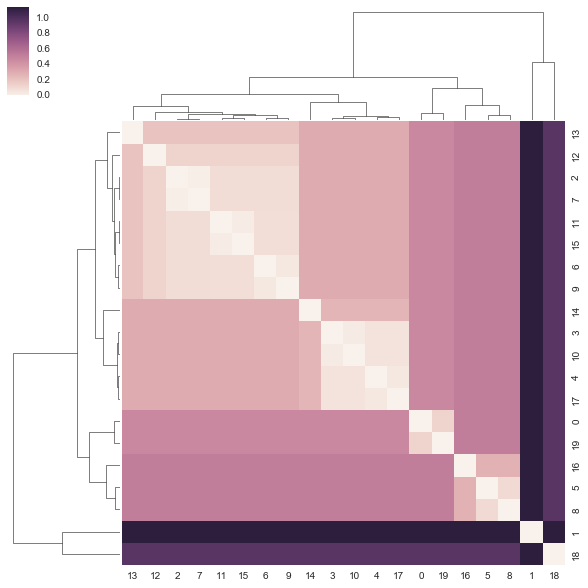

In [11]:
T3 = SuchTree( 'http://litoria.eeb.yale.edu/bird-tree/archives/PatchClade/Stage2/set1/Spheniscidae.tre' )

D3_list = []
for i,a in enumerate(T3.leafs.values()) :
    for j,b in enumerate( T3.leafs.values() ) :
        D3_list.append( ( a, b ) )
D3_array = array( D3_list )
D3 = T3.distances( D3_array )
D3 = D3.reshape( ( len(T3.leafs), len(T3.leafs) ) )

seaborn.clustermap(D3)

### Comparing the topologies of two large trees

Here, we use `SuchTree` to compare the topology of a two trees containing the taxa
but constructe with different methods ([`FastTree`](http://www.microbesonline.org/fasttree/) and 
[`neighbor joining`](https://en.wikipedia.org/wiki/Neighbor_joining)). One million random pairs are 
sampled from each tree, and the distances compared.

On my [rather elderly laptop](https://en.wikipedia.org/wiki/ThinkPad_X_Series#X200s), 
the distance calculations in both trees are completed in 22 seconds (most of which
is mapping the names to the node indicies).

In [4]:
T1 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )
T2 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree_nj.tree' )

print 'nodes : %d, leafs : %d' % ( T1.length, len(T1.leafs) )
print 'nodes : %d, leafs : %d' % ( T2.length, len(T2.leafs) )

nodes : 108653, leafs : 54327
nodes : 108653, leafs : 54327


In [13]:
import random

N = 1000000

v = T1.leafs.keys()

pairs = []
for i in range(N) :
    pairs.append( ( random.choice( v ), random.choice( v ) ) )

%time D1, D2 = T1.distances_by_name( pairs ), T2.distances_by_name( pairs )

CPU times: user 18.6 s, sys: 48 ms, total: 18.6 s
Wall time: 18.6 s


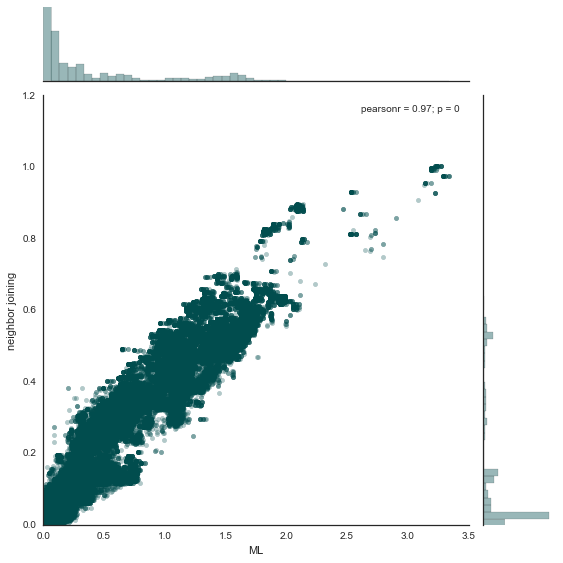

In [14]:
import pandas as pd


df = pd.DataFrame( { 'ML' : D1, 'neighbor joining' : D2 } )

with seaborn.axes_style("white"):
    seaborn.jointplot( 'ML', 'neighbor joining', data=df, color=seaborn.xkcd_rgb['dark teal'], alpha=0.3,
                       xlim=(0,3.5), ylim=(0,1.2), size=8 )

In [86]:
from scipy.stats import spearmanr, kendalltau, pearsonr

print 'Spearman\'s rs : %0.3f' % spearmanr( D1, D2 )[0]
print 'Kendall\'s tau : %0.3f' % kendalltau( D1, D2 )[0]
print 'Pearson\'s r   : %0.3f' % pearsonr( D1, D2 )[0]

Spearman's rs : 0.876
Kendall's tau : 0.708
Pearson's r   : 0.969


### Running with multiple threads

Another advantage of `SuchTree`'s support for performing batches of distance 
calculations is that these calculations can run outside of Python's 
[global interpreter lock](https://lbolla.info/blog/2013/12/23/python-threads-cython-gil).
This makes it possible to parallelize with [Threads](https://docs.python.org/2/library/threading.html).
Python's `Thread` has less overhead than the
[multiprocessing](https://docs.python.org/2/library/multiprocessing.html) package's
`Process`, and `Thread` objects can access the same memory. 

`SuchTree` intentionally does not allow the user to alter trees once they are created,
and so distance calculations are always thread safe. This makes it possible to use only 
*one* instance of a tree for all threads, which ought to give you the best chance of
keeping it within L2 cache.

In [14]:
%load_ext Cython

In [15]:
%%cython
import cython

def correlation( double[:] x, double[:] y ) :
    return _correlation( x, y )

@cython.boundscheck(False)
cdef double _correlation( double[:] x, double[:] y ) :
    cdef int n = x.shape[0]
    cdef int i = 0
    cdef double r = 0.0
    cdef double xbar = 0.0
    cdef double ybar = 0.0
    cdef double sx = 0.0
    cdef double sy = 0.0

    with nogil :
        for i in xrange(n) :
            xbar += x[i]
            ybar += y[i]
        xbar /= n
        ybar /= n
        
        # compute standard deviation of x and y
        for i in xrange(n) :
            sx += (x[i] - xbar) * (x[i] - xbar)
            sy += (y[i] - ybar) * (y[i] - ybar)
        
        sx = ( sx / n )**(0.5)
        sy = ( sy / n )**(0.5)
        
        # compute r, the correlation coefficient between the two arrays
        for i in xrange(n) :
            r += (((x[i] - xbar)/sx) * ((y[i] - ybar)/sy));
        r /= (n);
        return r

In [16]:
from threading import Thread
from Queue import Queue

n = 2
m = 12

work_q = Queue()
done_q = Queue()

for i in xrange( m ) :
    work_q.put( pairs )

for i in xrange( n ) :
    work_q.put( 'STOP' )
    
def worker( work_q, done_q ) :
    for task in iter( work_q.get, 'STOP' ) :
        D1 = T1.distances_by_name( task )
        D2 = T2.distances_by_name( task )
        r = correlation( D1, D2 )
        done_q.put( r )
    return True

threads = []

for i in xrange( n ) :
    thread = Thread( target=worker, args=( work_q, done_q ) )
    thread.start()
    threads.append( thread )
    
for thread in threads :
    thread.join()

done_q.put( 'STOP' )

for r in iter( done_q.get, 'STOP' ) :
    print r

0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425


### Working with linked trees

If you are interested in studying how two groups of organisms interact (or, 
rather, have interacted over evolutionary time), you will find yourself with 
two trees of distinct groups of taxa that are linked by a matrix of 
interaction observations. This is sometimes called a 'dueling trees' problem.

![dueling trees](docs/dueling_trees.png)

If the trees happen to have the same number of taxa, and the interaction 
matrix happens to be a unit matrix, then you can compute the distance matrix
for each of your tres and use the 
[Mantel test](https://en.wikipedia.org/wiki/Mantel_test) to compare them. 
However, this is a pretty special case. Hommola *et al.* describe a method 
extends the Mantel test in this paper here :

* [A Permutation Test of Host–Parasite Cospeciation](http://dx.doi.org/10.1093/molbev/msp062). *Molecular Biology and Evolution*, Vol. 26, No. 7. (01 July 2009), pp. 1457-1468, by Kerstin Hommola, Judith E. Smith, Yang Qiu, Walter R. Gilks

This is implemented in `scikit-bio` as [`hommola_cospeciation`](http://scikit-bio.org/docs/latest/generated/generated/skbio.stats.evolve.hommola_cospeciation.html).
Unfortunately, the version in `scikit-bio` does not scale to very large trees,
and does not expose the computed distances for analysis. This is where 
`SuchLinkedTrees` can help.

In [5]:
import pandas as pd

def foundon( df  ) :
    s = df.unstack()
    return s[ s > 0].to_dict().keys()

links = pd.read_csv( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_host_count_table.tsv', 
                    sep='\t', index_col='Host')
links.index = map( lambda x : x.replace(' ','_'), links.index )
F = map( lambda x : (T1.leafs[x[0]], T.leafs[x[1]]), foundon(links) )

F_a = np.array(F)
Fg = F_a[:,0]
Fh = F_a[:,1]

print 'total links :', len(F_a)
print 'link pairs  :', (len(F_a)*(len(F_a)-1))/2

total links : 149692
link pairs  : 11203772586


Holy cow, that's a lot of link pairs to test! `SuchLinkedTrees` provides
two functions for computing distances between through linked trees.

`SuchLinkedTrees.linked_distances` computes all of them, similar to the
`hommola_cospeciation` function in `scikit-bio`. However, it's probably
not a good use of everyone's time to compute 11 *billion* distances just
to put them into Pearson's Correlation.

So, instead, we'ere going to use `SuchLinkedTrees.sample_linked_distances`,
which extracts a representative sample of linked distances. It does this
by filling a user-specified number of buckets (default : 64) with distances
between randomly chosen link pairs. It stops when the standard deviation of
the standard deviation of the buckets falls bellow `sigma` (default : 0.001).

In [9]:
SLT = SuchLinkedTrees( T1, T, F_a )
SLT.links

array([[22206,     8],
       [90512,     8],
       [66126,    20],
       ..., 
       [34292,     8],
       [90340,    16],
       [81286,     6]])

Let's try sampling from those 11 billion link pairs until our 64 buckets
have a standard deviation of 0.001 of one another, using blocks of 4096 
pairs at a time.

In [15]:
%time result = SLT.sample_linked_distances( sigma=0.001, buckets=64, n=4096 )
print 'sampled link pairs :', len(result['TreeA'])
print 'Pearson\'s correlation : ', pearson( result['TreeA'], result['TreeB'] )
result

CPU times: user 7.07 s, sys: 16 ms, total: 7.09 s
Wall time: 7.13 s
sampled link pairs : 524288
Pearson's correlation :  -0.0162139965414


{'TreeA': array([ 0.2917802 ,  0.04970001,  1.08351529, ...,  0.19606017,
         0.06270004,  0.09308016]),
 'TreeB': array([ 0.28354204,  0.166352  ,  0.35418203, ...,  0.493772  ,
         0.166352  ,  0.29297599]),
 'sigma_a': 0.00056816547621207913,
 'sigma_b': 6.5499756492518046e-05}

Not too bad. The algorithm went through two iterations, placing two blocks of
4096 pairs into each bucket before it converged on our stopping condition for
a total of 524,288 pairs with a correlation of -0.016. 

Let's see what the distribution of sampled distances looks like.

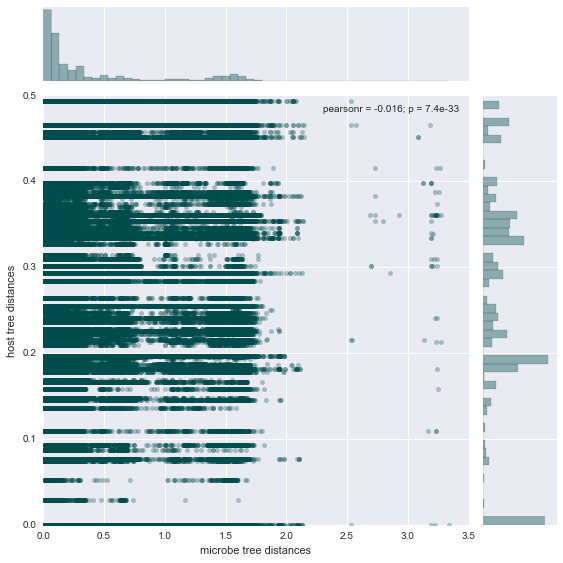

In [12]:
df = pd.DataFrame( { 'microbe tree distances' : result['TreeA'], 
                     'host tree distances'    : result['TreeB'] } )

seaborn.jointplot( 'microbe tree distances', 'host tree distances', data=df,
                   color=seaborn.xkcd_rgb['dark teal'], alpha=0.3,
                   xlim=(0,3.5), ylim=(0,0.5), size=8 )

### Searching for co-evolving clades

If one (or maybe both) of your trees represents organisms that have been sampled
using an unsupervised method, such as high throughput sequencing of 16S ribosomal 
RNA, you will may wish to examine clades within the tree.

This can be done by creating `SuchLinkedTrees` with different link lists. 

In [25]:
def linked_clades(SLT) :
    sfael = dict(zip( SLT.TreeA.leafs.values(), SLT.TreeA.leafs.keys() ))
    for id in SLT.TreeA.get_internal_nodes() :
        #l = list(SLT.TreeA.get_leafs( id ))
        #if len(l) < 5 : continue
        F = np.array( map( lambda x : (SLT.TreeA.leafs[x[0]], SLT.TreeB.leafs[x[1]]), 
                        foundon( links[ map( lambda x : sfael[x], SLT.TreeA.get_leafs( id ) ) ] ) ) )
        yield SuchLinkedTrees( SLT.TreeA, SLT.TreeB, F )

Nevertheless, these two instances of `SuchLinkedTrees` share the same
`SuchTree` instances. This allows you to create many `SuchLinkedTree`
instances expressing diffrent link lists without duplicating the 
tree data.

In [24]:
SLT1 = SuchLinkedTrees( T1, T, F_a[100:] )
SLT2 = SuchLinkedTrees( T1, T, F_a[200:] )
print 'memmory id of SLT1 : ', id(SLT1)
print 'memmory id of SLT2 : ', id(SLT2)
print 'memmory id of SLT1.TreeA : ', id(SLT1.TreeA)
print 'memmory id of SLT2.TreeA : ', id(SLT2.TreeA)
print 'memmory id of SLT1.TreeB : ', id(SLT1.TreeB)
print 'memmory id of SLT2.TreeB : ', id(SLT2.TreeB)
del(SLT1, SLT2)

memmory id of SLT1 :  140147734807752
memmory id of SLT2 :  140147734808480
memmory id of SLT1.TreeA :  140147280440528
memmory id of SLT2.TreeA :  140147280440528
memmory id of SLT1.TreeB :  140148609549968
memmory id of SLT2.TreeB :  140148609549968


In [92]:
from itertools import combinations
import pyprind

N = len(list(T1.get_internal_nodes()))

sfael = dict( zip( T1.leafs.values(), T1.leafs.keys() ) )

def paired_distances( id ) :
    clade = map( lambda x : sfael[x], T1.get_leafs(id) )
    if len(clade) > 500 : raise Exception( 'clade too big', id )
    if len(clade) < 6 :   raise Exception( 'clade too small', id )
    l = foundon(links[clade])
    if len(l) < 10 : raise Exception( 'too few links', id )
    gpairs, hpairs = [],[]
    for (g1,h1),(g2,h2) in combinations( l, 2 ) :
        gpairs.append( (g1,g2) )
        hpairs.append( (h1,h2) )
    gd = T1.distances_by_name( gpairs )
    hd = T.distances_by_name( hpairs )
    return { 'length' : len(clade), 'n_links' : len(l), 'guest distances' : gd, 'host distances' : hd }

progbar = pyprind.ProgBar( N, monitor=True, title='computing distances...' )

results = []
for n,id in enumerate( T1.get_internal_nodes() ) :
    progbar.update()
    #if n > N : break
    try :
        result = paired_distances( id )
        row = {}
        pr,pp = pearsonr( result['guest distances'], result['host distances'] )
        sr,sp = spearmanr( result['guest distances'], result['host distances'] )
        row[ 'pearsonr' ] = pr
        row[ 'pearsonp' ] = pp
        row[ 'spearmanr' ] = sr
        row[ 'spearmanp' ] = sp
        row[ 'length' ] = result[ 'length' ]
        row[ 'n_links' ] = result[ 'n_links' ]
        row[ 'id' ] = id
        results.append( row )
    except Exception as error :
        continue
    

computing distances...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:42:06


In [94]:
result = paired_distances( sorted(results, key=lambda x : x['pearsonr'] )[-1]['id'] )
seaborn.jointplot(result['guest distances'], result['host distances'] )

KeyError: 'id'

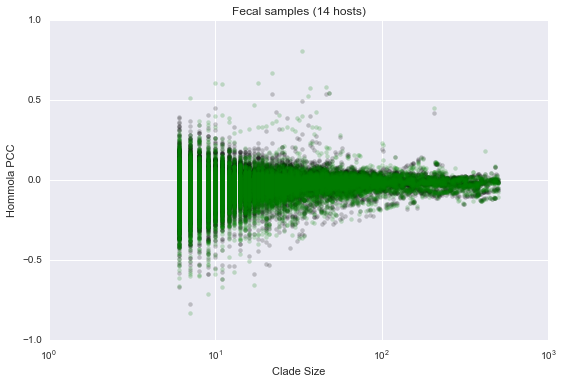

In [95]:
R = pd.DataFrame( results )

scatter( R.length, R.spearmanr, lw=0, c='k', alpha=0.2 )
scatter( R.length, R.pearsonr, lw=0, c='g', alpha=0.2 )
title( 'Fecal samples (14 hosts)')
xlabel( 'Clade Size' )
ylabel( 'Hommola PCC' )
semilogx()
tight_layout()

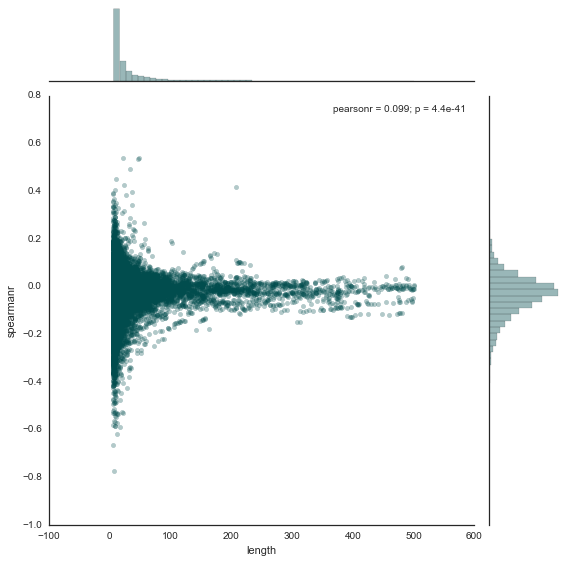

In [100]:
with seaborn.axes_style("white"):
    seaborn.jointplot( 'length', 'spearmanr', data=R, color=seaborn.xkcd_rgb['dark teal'], alpha=0.3, size=8 )

In [35]:
SLT1 = SuchLinkedTrees( T1, T, F_a )
SLT2 = SuchLinkedTrees( T1, T, F_a )

In [38]:
SLT1.TreeA

In [39]:
SLT2.TreeA

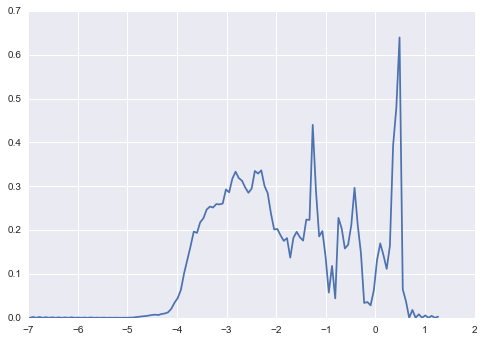

In [32]:
seaborn.kdeplot(log(D1), bw=0.02 )

In [16]:
len(clade.linked_leafsA)

616

2218671
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 22.6 ms


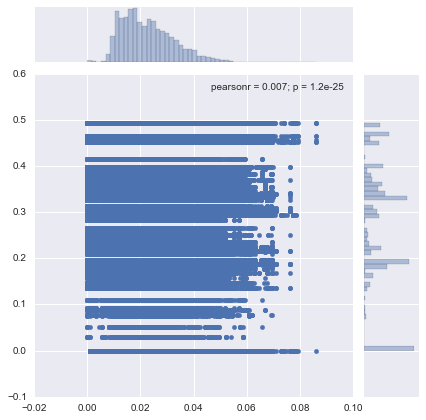

In [13]:
a,b = clade.linked_distances()
print len(a)
%time pearson( a, b )
seaborn.jointplot( a, b )

In [8]:
%%time
clades = []
for n,clade in enumerate(linked_clades(SLT)) :
    if n > 1000 : break
    if clade.n_links < 5 : continue
    
    clades.append(clade.sample_linked_distances())

KeyboardInterrupt: 

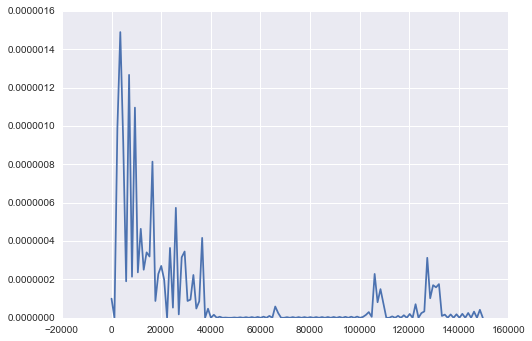

In [118]:
seaborn.kdeplot( array( map( lambda x : x.n_links, clades ) ) )

In [76]:
sfael = dict(zip( SLT.TreeA.leafs.values(), SLT.TreeA.leafs.keys() ))

In [77]:
map( lambda x : sfael[x], SLT.TreeA.get_leafs( 5033 ))

['TRIGOTO3_70670',
 'CYPRCOL2_99558',
 'LOBOLAB1_67687',
 'CYPRCOL3_252311',
 'LOBOLAB1_26063',
 'TRIGOTO1_148793',
 'LOBOLAB1_30555',
 'TANGIRA1_155093',
 'CYPRCOL2_12439',
 'CYPRCOL4_76200']

In [85]:
import sys

sys.getsizeof(SLT.TreeA)

80

In [40]:
set(links.axes[0]) == set(T.leafs.keys())

True

In [59]:
s = links[links.columns[100]]
map( lambda x : T.leafs[x], s[ s > 0 ].to_dict().keys() )

[8, 6, 0, 26, 16]

In [63]:
np.zeros( (2, 3), dtype=bool )

array([[False, False, False],
       [False, False, False]], dtype=bool)

In [66]:
T.leafs.values().index(2)

5

In [6]:
SLT = SuchLinkedTrees( T, T1, links )

In [12]:
row_ids = SLT.TreeA.leafs.values()
for i in xrange( )

[8, 14, 12, 4, 18, 2, 6, 24, 20, 0, 26, 16, 10, 22]

In [7]:
%time SLT.subset_guest_tree( SLT.TreeB.root )

CPU times: user 35.4 s, sys: 12 ms, total: 35.4 s
Wall time: 35.6 s


In [35]:
LL = pd.DataFrame( numpy.random.random_integers( 0, 3, size=(14,14)), columns=T.leafs.keys(), index=T.leafs.keys() )

In [14]:
%prun SLT.subset_guest_tree( SLT.TreeB.root )

In [8]:
T.dump_array()

id : 0 ->
   distance    : 0.047
   parent      : 1
   left child  : -1
   right child : -1
id : 1 ->
   distance    : 0.067
   parent      : 3
   left child  : 0
   right child : 2
id : 2 ->
   distance    : 0.037
   parent      : 1
   left child  : -1
   right child : -1
id : 3 ->
   distance    : 0.007
   parent      : 5
   left child  : 1
   right child : 4
id : 4 ->
   distance    : 0.157
   parent      : 3
   left child  : -1
   right child : -1
id : 5 ->
   distance    : 0.003
   parent      : 13
   left child  : 3
   right child : 7
id : 6 ->
   distance    : 0.146
   parent      : 7
   left child  : -1
   right child : -1
id : 7 ->
   distance    : 0.079
   parent      : 5
   left child  : 6
   right child : 9
id : 8 ->
   distance    : 0.038
   parent      : 9
   left child  : -1
   right child : -1
id : 9 ->
   distance    : 0.053
   parent      : 7
   left child  : 8
   right child : 11
id : 10 ->
   distance    : 0.015
   parent      : 11
   left child  : -1
   right child

In [1]:
T1

NameError: name 'T1' is not defined